In [1]:
%pip install pandas openpyxl torch scikit-learn facenet-pytorch matplotlib torchsampler opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Assuming the xlsx file is named 'data.xlsx'
df = pd.read_excel('dataset/combined.xlsx', engine='openpyxl')

imgs_with_decay = df[df['R'] == 1] # get all rows where the df['B'] is 1
imgs_without_decay = df[df['R'] == 0] # get all rows where the df['C'] is 1

greater = imgs_with_decay if len(imgs_with_decay) > len(imgs_without_decay) else imgs_without_decay
smaller = imgs_without_decay if len(greater) == len(imgs_with_decay) else imgs_with_decay
smaller = smaller.sample(frac=len(greater)/len(smaller), replace=True)

df = pd.concat([df, smaller])

lst = []
for index, row in df.iterrows():
    lst.append([row['A'], float(row['R']==1), float(row['R']==0) ])

df = pd.DataFrame(lst, columns=['A', 'B', 'C'])

# Extract image names and class labels
image_names = df['A'].tolist()
class_labels = df[['B', 'C']].values

print(class_labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [35]:
from PIL import Image
from torchvision import transforms

global_tranformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([
        transforms.RandomAffine(0),
        transforms.ColorJitter(),
        transforms.GaussianBlur(5),
    ]),
])

def load_image(image_path):
    img = Image.open(image_path).convert('RGB') # Open and convert to RGB
    return global_tranformer(img)

In [4]:
import torch.utils
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch.utils.data
from torchvision import transforms
import torch

# empty image dictionary map<string,Image>


class MyData(Dataset):
    def __init__(self, images_names, class_labels, transform=None):
        self.images_names = images_names
        self.class_labels = class_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, index):
        image = self.images_names[index]
        label = self.class_labels[index]
        
        # get image from dictionary or load it
        image_path = "/root/ortho-ai/dataset/imgs/" + image
        
        image = load_image(image_path)
        
        return image, label
    


# Split data into training and test sets (80% training, 20% test)
images_train, images_test, labels_train, labels_test = train_test_split(image_names, class_labels, test_size=0.2, random_state=42)

# Calculate class weights based on the presence of each class across all columns
class_counts = torch.sum(torch.tensor(class_labels), dim=0)
class_weights = 1. / class_counts.float()

# Create a list of weights for each training sample
weights = torch.sum(class_weights[labels_train], dim=1)

# Create WeightedRandomSampler for imbalanced classes
sampler = WeightedRandomSampler(weights, len(weights))

# Create your dataset
train_dataset = MyData(images_train, labels_train, )
full_dataset = MyData(image_names, class_labels,)
test_dataset = MyData(images_test, labels_test)

# Create a DataLoader
train_dataloader = DataLoader(full_dataset, batch_size=32, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [5]:
from torchvision.models import resnet50 # You can choose other ResNet models like resnet34, resnet50, etc.
import torch
import torch.optim as optim

# Load the ResNet model
model = resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the final layer to match the number of classes
num_classes = 2 # Adjust this to the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
num_epochs = 12
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Convert labels to LongTensor
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}")

print("Finished Training")

Epoch 1, Loss: 0.4905264886717002
Epoch 2, Loss: 0.3080626943459113
Epoch 3, Loss: 0.2339847469258876
Epoch 4, Loss: 0.22079151783448955
Epoch 5, Loss: 0.12165711495271396
Epoch 6, Loss: 0.09322719394029784
Epoch 7, Loss: 0.13780043860675678
Epoch 8, Loss: 0.09230059266112567
Epoch 9, Loss: 0.05034543183449257
Epoch 10, Loss: 0.06765468902830478
Epoch 11, Loss: 0.03944532126895085
Epoch 12, Loss: 0.020401017914991826
Finished Training


In [6]:
# Evaluate model accuracy on the test set after training
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval() # Set model to evaluation mode

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Convert labels to LongTensor (assuming class labels are integers)
            labels = labels.long()

            outputs = model(images)
            # Apply sigmoid to get probabilities
            probabilities = torch.sigmoid(outputs)
            # Convert probabilities to binary predictions
            predicted = (probabilities > 0.5).long()

            total += labels.size(0)
            # Calculate correct predictions for each sample
            correct_sample = (predicted == labels).all(dim=1).sum().item()
            correct += correct_sample

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_dataloader)

Test Accuracy: 99.55%


In [1]:
import torch
# Preprocess the image
image = Image.open('test_imgs/WhatsApp Image 2024-05-03 at 17.02.21.jpeg').convert('RGB')
image_tensor = global_tranformer(image).unsqueeze(0) # Add batch dimension

# Move the tensor to the device
image_tensor = image_tensor.to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)

# Convert logits to probabilities using softmaxa
probabilities = torch.nn.functional.softmax(output, dim=1)

# Print the probabilities for all classes
print("Probabilities for all classes:")
for i, prob in enumerate(probabilities[0]):
    print(f"Class {i+1}: {prob.item()}")

NameError: name 'Image' is not defined

In [8]:
# import torch

# torch.save(model, "./models/spacing_2_v0.3.pth")

In [36]:
import torch
model = torch.load("models/tooth-decay.pth")

In [37]:
from PIL import Image
from facenet_pytorch import MTCNN
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt


def get_mouth_landmarks(image):
    # Load an image from a local file

    # Initialize MTCNN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device)

    # Detect faces and landmarks
    boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

    # Check if any faces were detected
    if landmarks is not None:
        # Assuming landmarks for the first detected face
        mouth_landmarks = landmarks[0][3:5] # Mouth landmarks
        return mouth_landmarks
    else:
        print("No faces detected in the image.")
        return None


def rotate_image_to_horizontal_mouth(image, mouth_landmarks):
    # Calculate the angle needed to rotate the image so that the mouth is horizontal
    mouth_left = mouth_landmarks[0]
    mouth_right = mouth_landmarks[1]
    angle = np.arctan2(mouth_right[1] - mouth_left[1], mouth_right[0] - mouth_left[0])

    # Convert the angle to degrees
    angle = np.degrees(angle)

    # Rotate the image
    (h, w) = image.size
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    open_cv_image = np.array(image)
    rotated_image = cv2.warpAffine(open_cv_image, M, (h, w))

    # Convert the rotated image back to PIL Image for display
    rotated_image_pil = Image.fromarray(rotated_image)
    return rotated_image_pil

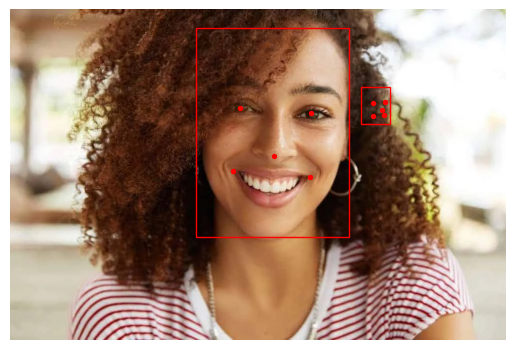

In [38]:
from matplotlib import pyplot as plt
from facenet_pytorch import MTCNN
from PIL import Image

# Load an image from a local file
image_path = 'test_imgs/girl-smile.webp'
image = Image.open(image_path).convert('RGB')  # Convert image to RGB right after opening

# Initialize MTCNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# Detect faces and landmarks
boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

# Visualize the detection (optional)
fig, ax = plt.subplots()
ax.imshow(image)
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c='red')
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red')
        ax.add_patch(rect)
plt.axis('off')
plt.show()

# Rotate the image based on mouth landmarks to make the mouth horizontal
mouth_landmarks = landmarks[0][3:5]  # Assuming landmarks for the first detected face

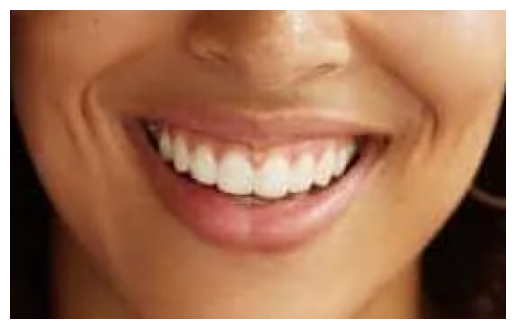

In [39]:
margin = 60
mouth_box = [
    min(mouth_landmarks[:,0]) - margin,        # Left
    min(mouth_landmarks[:,1]) - margin,        # Top
    max(mouth_landmarks[:,0]) + margin,        # Right
    max(mouth_landmarks[:,1]) + margin + 40    # Bottom
    ]
mouth_crop = image.crop((mouth_box[0], mouth_box[1], mouth_box[2], mouth_box[3]))

# Display the cropped mouth region
plt.imshow(mouth_crop)
plt.axis('off')
plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Probabilities for all classes:
Class 1: 0.00013135053450241685
Class 2: 0.999868631362915
Predicted class: No Decay


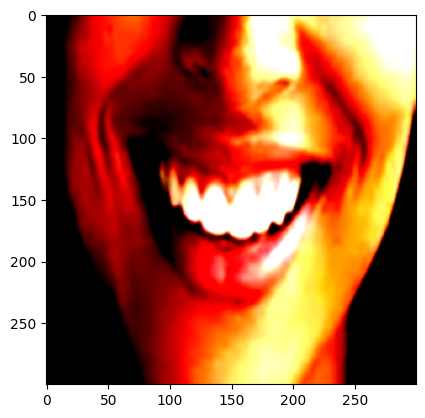

In [44]:
# Preprocess the image
aug_img = global_tranformer(mouth_crop) # Add batch dimension

# Move the tensor to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = aug_img.unsqueeze(0).to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(output, dim=1)

# Print the probabilities for all classes
print("Probabilities for all classes:")
for i, prob in enumerate(probabilities[0]):
    print(f"Class {i+1}: {prob.item()}")
    
# Assuming the classes are ordered as follows: Flat, Reversed, Parallel
classes = ["Decay", "No Decay"]

# Find the index of the maximum probability
max_prob_index = torch.argmax(probabilities[0]).item()

# Map the index to the class name
predicted_class = classes[max_prob_index]

# Print the predicted class
print(f"Predicted class: {predicted_class}")

# show augmented image and moth crop next to each other
plt.imshow(aug_img.cpu().permute(1, 2, 0).numpy())